In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.io as scio
from scipy.optimize import root
from matplotlib.font_manager import FontProperties

rural = np.arange(0, 60, 2)
urban = np.arange(1, 60, 2)
east = np.r_[0, 1, 2, 3, 4, 5, 16, 17, 18, 19, 20, 21, 24, 25, 28, 29, 36, 37, 40, 41]
middle = np.r_[6, 7, 22, 23, 26, 27, 30, 31, 32, 33, 34, 35]
west = np.r_[8, 9, 10, 11, 12, 13, 14, 15, 38, 39, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
high_flow_in = [0, 1, 2, 3, 8, 10, 12, 18, 20] # highest 30%
low_flow_in = [4, 5, 6, 7, 9, 11, 13, 14, 15, 16, 17, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29] 

font_path = r'C:\Windows\Fonts\simsun.ttc'
chinese_font = FontProperties(fname=r'C:\Windows\Fonts\simsun.ttc')
english_font = FontProperties(fname=r'C:\Windows\Fonts\arial.ttf')
pd.options.display.float_format = '{:.3f}'.format

def gini_index(array):
    cum_wealths = np.cumsum(sorted(np.append(array, 0)))
    sum_wealths = cum_wealths[-1]
    xarray = np.array(range(0, len(cum_wealths))) / float(len(cum_wealths)-1)
    yarray = cum_wealths / sum_wealths
    B = np.trapz(yarray, x=xarray)
    A = 0.5 - B
    return A / (A + B)


In [3]:
# import variables and parameters

equilibrium2010 = np.load('./data/equilibrium2010.npz')
R = equilibrium2010['R']
X = equilibrium2010['X']
m = equilibrium2010['m']
pi = equilibrium2010['pi']
L = equilibrium2010['L']
L_bar = equilibrium2010['L_bar']
K = equilibrium2010['K']
w = equilibrium2010['w']
P = equilibrium2010['P']
W = equilibrium2010['W']

parameter = np.load('./data/Parameter.npz')
kappa = parameter['kappa']
theta = parameter['theta']
beta = parameter['beta']
psi_ag = parameter['psi_ag']
psi_na = parameter['psi_na']
alpha_ag = parameter['alpha_ag']
alpha_na = parameter['alpha_na']
sigma_ag = parameter['sigma_ag']
sigma_na = parameter['sigma_na']
eta_ag_ag = parameter['eta_ag_ag']
eta_ag_na = parameter['eta_ag_na']
eta_na_ag = parameter['eta_na_ag']
eta_na_na = parameter['eta_na_na']
phiu = parameter['phiu']
phip = parameter['phip']
chi = parameter['chi']
eta = parameter['eta']
delta = parameter['delta']
xi_ag = parameter['xi_ag']
xi_na = parameter['xi_na']
t = parameter['t']

In [4]:
# import the change in exogenous variables

## 2002-2017 land supply
K0217 = np.array(pd.read_excel('./data/raw_and_build/2002-2017年各省份建设用地面积.xlsx').iloc[:, 2:])
K0217 = np.delete(K0217, 25, axis=0) # remove Xizang
dK0317 = K0217[:, 1:] / K0217[:, :-1]
dK0317 = K0217[:, 1:] / K0217[:, :-1]

## land supply
K1017 = np.array(pd.read_excel('./data/raw_and_build/城镇村及工矿用地面积.xlsx').iloc[:, 3:])
K1017 = np.delete(K1017, 25, axis=0) # remove Xizang
dK1117 = K1017[:, 1:] / K1017[:, 0].reshape([30, 1])
dK1117 = K1017[:, 1:] / K1017[:, 0].reshape([30, 1])

dKh = np.concatenate([np.ones([30, 1]), dK1117[:, -1].reshape([30, 1])], axis=1).reshape([60, 1])
dKp = np.concatenate([np.ones([30, 1]), dK1117[:, -1].reshape([30, 1])], axis=1).reshape([60, 1])
dT = np.ones([60, 1])
dtau = np.ones([60, 60])
dmu = np.ones([60, 60])

In [5]:
# solve the equilibrium after land reform

def SolveCounter(XX):
    dw = XX[:60].reshape([60, 1])
    dL = XX[60:120].reshape([60, 1])
    dp = XX[120:].reshape([60, 1])

    ## (a) change in price index
    dpdp_wp_c = np.repeat((dp.reshape([30, 2]) ** np.array([psi_ag * beta, psi_na * beta]).reshape([1, 2])).prod(axis=1).reshape([30, 1]), 2, axis=1).reshape([60, 1])
    drh = dw * dL / dKh
    dP =  dpdp_wp_c *  (drh ** (1 - beta))

    ## (b) change in public expenditures
    dG = dw * dL / dP

    ## (c) change in the price of unit input bundle
    dw_wp = (dw.reshape([30, 2]) ** np.array([alpha_ag, alpha_na]).reshape([1, 2])).reshape([60, 1])
    drp = dw * dL / dKp
    drp_wp = (drp.reshape([30, 2]) ** np.array([sigma_ag, sigma_na]).reshape([1, 2])).reshape([60, 1])
    dpdp_wp_p_ag = (dp.reshape([30, 2]) ** np.array([eta_ag_ag, eta_na_ag]).reshape([1, 2])).prod(axis=1).reshape([30, 1])
    dpdp_wp_p_na = (dp.reshape([30, 2]) ** np.array([eta_ag_na, eta_na_na]).reshape([1, 2])).prod(axis=1).reshape([30, 1])
    dpdp_wp_p = np.concatenate([dpdp_wp_p_ag, dpdp_wp_p_na], axis=1).reshape([60, 1])
    dc = dw_wp * drp_wp * dpdp_wp_p

    ## (d) change in the trade share
    dpi_num = dT * ((dtau * dc) ** (-theta)) * (dG ** (phip * theta)) * (dL ** (theta * delta))
    dpi_den = (dpi_num * pi).sum(axis=0).reshape([60, 1])
    dpi = (dpi_num.T / dpi_den).T
    pi_prime = pi * dpi

    ## (e) change in the price of final goods
    dp1 = dpi_den ** (-1 / theta)

    ## (f) change in the income ratio
    wL = (R.reshape([30, 2]) * np.array([alpha_ag, alpha_na]).reshape([1, 2])).reshape([60, 1])
    w = wL / L
    w_prime = w * dw
    coef_rK_ag = (alpha_ag + sigma_ag - (beta + t - beta * t) * alpha_ag) / ((beta + t - beta * t) * alpha_ag)
    coef_rK_na = sigma_na / alpha_na + (1 - beta) * (1 - t)
    rKrK = (wL.reshape([30, 2]) * np.array([coef_rK_ag, coef_rK_na]).reshape([1, 2])).reshape([60, 1])
    rho_prime = rKrK * dw * dL / L_bar
    rho_prime[1::2] = 0 
    delta_prime = 1 + (w_prime ** (-1)) @ rho_prime.T
    delta_diag = ((L / (L_bar * np.diag(m).reshape([60, 1]))).reshape([30, 2]) * np.array([coef_rK_ag, 0]).reshape([1, 2]) + 1).reshape([60, 1])
    ddelta = delta_prime
    np.fill_diagonal(ddelta, np.diag(delta_prime).reshape([60, 1]) / delta_diag)

    ## (g) change in the migration share 
    dg = dG / (dL ** chi)
    dW = dw / dP 
    dm_num = (ddelta * (dmu ** (-1)) * (dg ** phiu) * dW) ** kappa
    dm_den = (dm_num * m).sum(axis=0).reshape([60, 1])
    dm = (dm_num.T / dm_den).T
    m_prime = m * dm

    ## (h) change in the numebr of residents
    dL1 = (m_prime @ L_bar) / L

    ## (i) total outputs and expenditures under the equilibrium
    R_prime = R * dw * dL
    wL_prime = wL * dw * dL
    X_prime = np.linalg.inv(pi_prime) @ R_prime
    vL_prime = (wL_prime.reshape([30, 2]) * np.array([(alpha_ag + sigma_ag) / (beta + t - beta * t) / alpha_ag, 1]).reshape([1, 2])).reshape([60, 1])
    PG_prime = (wL_prime.reshape([30, 2]) * np.array([t * (alpha_ag + sigma_ag) / (beta + t - beta * t) / alpha_ag, 1 - beta + sigma_na / alpha_na + beta * t]).reshape([1, 2])).reshape([60, 1])
    A_prime = (beta * (1 - t) * np.repeat(vL_prime.reshape([30, 2]).sum(axis=1).reshape([30, 1]), 2, axis=1) * np.array([psi_ag, psi_na]).reshape([1, 2])).reshape([60, 1])
    C_prime = (np.repeat(PG_prime.reshape([30, 2]).sum(axis=1).reshape([30, 1]), 2, axis=1) * np.array([xi_ag, xi_na]).reshape([1, 2])).reshape([60, 1])
    B_ag_prime = ((R_prime.reshape([30, 2]) * np.array([eta_ag_ag, eta_ag_na]).reshape([1, 2])).sum(axis=1)).reshape([30, 1])
    B_na_prime = ((R_prime.reshape([30, 2]) * np.array([eta_na_ag, eta_na_na]).reshape([1, 2])).sum(axis=1)).reshape([30, 1])
    B_prime = np.concatenate([B_ag_prime, B_na_prime], axis=1).reshape([60, 1])
    X_prime1 = A_prime + B_prime + C_prime 

    ## (j) conditions for the equilibrium
    res1 = dp1 - dp
    res2 = dL1 - dL
    res3 = X_prime1 - X_prime

    return np.concatenate([res1, res2, res3]).flatten().astype(float)

In [6]:
# save the variables

def counterfautual_result(dw, dL, dp):
    dpdp_wp_c = np.repeat((dp.reshape([30, 2]) ** np.array([psi_ag * beta, psi_na * beta]).reshape([1, 2])).prod(axis=1).reshape([30, 1]), 2, axis=1).reshape([60, 1])
    drh = dw * dL / dKh
    dP =  dpdp_wp_c *  (drh ** (1 - beta))
    dG = dw * dL / dP
    dw_wp = (dw.reshape([30, 2]) ** np.array([alpha_ag, alpha_na]).reshape([1, 2])).reshape([60, 1])
    drp = dw * dL / dKp
    drp_wp = (drp.reshape([30, 2]) ** np.array([sigma_ag, sigma_na]).reshape([1, 2])).reshape([60, 1])
    dpdp_wp_p_ag = (dp.reshape([30, 2]) ** np.array([eta_ag_ag, eta_na_ag]).reshape([1, 2])).prod(axis=1).reshape([30, 1])
    dpdp_wp_p_na = (dp.reshape([30, 2]) ** np.array([eta_ag_na, eta_na_na]).reshape([1, 2])).prod(axis=1).reshape([30, 1])
    dpdp_wp_p = np.concatenate([dpdp_wp_p_ag, dpdp_wp_p_na], axis=1).reshape([60, 1])
    dc = dw_wp * drp_wp * dpdp_wp_p
    dpi_num = dT * ((dtau * dc) ** (-theta)) * (dG ** (phip * theta)) * (dL ** (theta * delta))
    dpi_den = (dpi_num * pi).sum(axis=0).reshape([60, 1]) 
    dpi = (dpi_num.T / dpi_den).T
    pi_prime = pi * dpi
    wL = (R.reshape([30, 2]) * np.array([alpha_ag, alpha_na]).reshape([1, 2])).reshape([60, 1])
    w = wL / L 
    w_prime = w * dw
    coef_rK_ag = (alpha_ag + sigma_ag - (beta + t - beta * t) * alpha_ag) / ((beta + t - beta * t) * alpha_ag)
    coef_rK_na = sigma_na / alpha_na + (1 - beta) * (1 - t)
    rKrK = (wL.reshape([30, 2]) * np.array([coef_rK_ag, coef_rK_na]).reshape([1, 2])).reshape([60, 1]) 
    rho_prime = rKrK * dw * dL / L_bar
    rho_prime[1::2] = 0 
    delta_prime = 1 + (w_prime ** (-1)) @ rho_prime.T
    delta_diag = ((L / (L_bar * np.diag(m).reshape([60, 1]))).reshape([30, 2]) * np.array([coef_rK_ag, 0]).reshape([1, 2]) + 1).reshape([60, 1]) 
    ddelta = delta_prime
    np.fill_diagonal(ddelta, np.diag(delta_prime).reshape([60, 1]) / delta_diag)
    dg = dG / (dL ** chi)
    dW = dw / dP 
    dm_num = (ddelta * (dmu ** (-1)) * (dg ** phiu) * dW) ** kappa
    dm_den = (dm_num * m).sum(axis=0).reshape([60, 1]) 
    dm = (dm_num.T / dm_den).T
    m_prime = m * dm
    R_prime = R * dw * dL
    X_prime = np.linalg.inv(pi_prime) @ R_prime 

    return dg, dc, dpi, pi_prime, dP, ddelta, dW, dm, m_prime, R_prime, X_prime, drh, dG, delta_diag

In [7]:
# define the funciton to calculate welfare

def welfare():
    coef_g_na = 1 - beta + sigma_na / alpha_na + beta * t
    coef_g_ag = (alpha_ag + sigma_ag) * t / (beta + t - beta * t) / alpha_ag
    g = ((w * L).reshape([30, 2]) * np.array([coef_g_ag, coef_g_na]).reshape([1, 2])).reshape([60, 1]) / P / (L ** chi)
    
    dV = dW * ((dg) ** phiu) * (np.diag(dm).reshape([-1, 1]) ** (-1 / kappa)) * (np.diag(ddelta).reshape([-1, 1]))

    weight = (np.diag(m).reshape([-1, 1]) ** (-1 / kappa)) * (g ** phiu) * W * L_bar * delta_diag
    weight_country = weight / weight.sum()
    weight_urban = weight[urban] / weight[urban].sum()
    weight_rural = weight[rural] / weight[rural].sum()
    weight_east = weight[east] / weight[east].sum()
    weight_middle = weight[middle] / weight[middle].sum()
    weight_west = weight[west] / weight[west].sum()

    dV_country = ((dV * weight_country).sum() - 1) * 100
    dV_urban = ((dV[urban] * weight_urban).sum() - 1) * 100
    dV_rural = ((dV[rural] * weight_rural).sum() - 1) * 100
    dV_east = ((dV[east] * weight_east).sum() - 1) * 100
    dV_middle = ((dV[middle] * weight_middle).sum() - 1) * 100
    dV_west = ((dV[west] * weight_west).sum() - 1) * 100
    
    return dV, dV_country, dV_urban, dV_rural, dV_east, dV_middle, dV_west

In [8]:
# Solve the counterfactural equilibrium (considering the change in land areas)

XX = root(SolveCounter, x0=np.ones(3*60), method='lm')
dw = XX.x[:60].reshape([60, 1])
dL = XX.x[60:120].reshape([60, 1])
dp = XX.x[120:].reshape([60, 1])
dg, dc, dpi, pi_prime, dP, ddelta, dW, dm, m_prime, R_prime, X_prime, drh, dG, delta_diag = counterfautual_result(dw, dL, dp)
W = w / P
w_prime = w * dw
L_prime = L * dL
P_prime = P * dP
W_prime = w_prime / P_prime

In [9]:
# summary table (Table 4)

## total outputs
dX_country = ((X_prime / P_prime).sum() / (X / P).sum() - 1) * 100
dX_urban = ((X_prime / P_prime)[urban].sum() / (X / P)[urban].sum() - 1) * 100
dX_rural = ((X_prime / P_prime)[rural].sum() / (X / P)[rural].sum() - 1) * 100
dX_east = ((X_prime / P_prime)[east].sum() / (X / P)[east].sum() - 1) * 100
dX_middle = ((X_prime / P_prime)[middle].sum() / (X / P)[middle].sum() - 1) * 100
dX_west = ((X_prime / P_prime)[west].sum() / (X / P)[west].sum() - 1) * 100

## numbers of residents
dL_urban = (L_prime[urban].sum() / L[urban].sum() - 1) * 100
dL_rural = (L_prime[rural].sum() / L[rural].sum() - 1) * 100
dL_east = (L_prime[east].sum() / L[east].sum() - 1) * 100
dL_middle = (L_prime[middle].sum() / L[middle].sum() - 1) * 100
dL_west = (L_prime[west].sum() / L[west].sum() - 1) * 100

## real gdp per capita
dW_country = (((W_prime * L_prime).sum() / L_prime.sum()) / ((W * L).sum() / L.sum()) - 1) * 100
dW_urban = (((W_prime * L_prime)[urban].sum() / L_prime[urban].sum()) / ((W * L)[urban].sum() / L[urban].sum()) - 1) * 100
dW_rural = (((W_prime * L_prime)[rural].sum() / L_prime[rural].sum()) / ((W * L)[rural].sum() / L[rural].sum()) - 1) * 100
dW_east = (((W_prime * L_prime)[east].sum() / L_prime[east].sum()) / ((W * L)[east].sum() / L[east].sum()) - 1) * 100
dW_middle = (((W_prime * L_prime)[middle].sum() / L_prime[middle].sum()) / ((W * L)[middle].sum() / L[middle].sum()) - 1) * 100
dW_west = (((W_prime * L_prime)[west].sum() / L_prime[west].sum()) / ((W * L)[west].sum() / L[west].sum()) - 1) * 100

## public expenditures per capita
coef_g_na = 1 - beta + sigma_na / alpha_na + beta * t
coef_g_ag = (alpha_ag + sigma_ag) * t / (beta + t - beta * t) / alpha_ag
dg_country = (
        (((w_prime * L_prime / P_prime)[urban] * coef_g_na).sum() + ((w_prime * L_prime / P_prime)[rural] * coef_g_ag).sum()) / 
        (((w * L / P)[urban] * coef_g_na).sum() + ((w * L / P)[rural] * coef_g_ag).sum())
    - 1) * 100
dg_urban = (
        ((w_prime * L_prime / P_prime)[urban].sum() / (L_prime[urban].sum() ** chi)) / 
        ((w * L / P)[urban].sum() / (L[urban].sum() ** chi)) 
    - 1) * 100
dg_rural = (
        ((w_prime * L_prime / P_prime)[rural].sum() / (L_prime[rural].sum() ** chi)) / 
        ((w * L / P)[rural].sum() / (L[rural].sum() ** chi)) 
    - 1) * 100

## housing price
drh_country = ((drh / dP).mean() - 1) * 100
drh_urban = ((drh / dP)[urban].mean() - 1) * 100
drh_rural = ((drh / dP)[rural].mean() - 1) * 100
drh_east = ((drh / dP)[east].mean() - 1) * 100
drh_middle = ((drh / dP)[middle].mean() - 1) * 100
drh_west = ((drh / dP)[west].mean() - 1) * 100

## gini coefficients for real gdp per capita
dincgini_country = (gini_index(W_prime) / gini_index(W) - 1) * 100
dincgini_urban = (gini_index(W_prime[urban]) / gini_index(W[urban]) - 1) * 100
dincgini_rural = (gini_index(W_prime[rural]) / gini_index(W[rural]) - 1) * 100
dincgini_east = (gini_index(W_prime[east]) / gini_index(W[east]) - 1) * 100
dincgini_middle = (gini_index(W_prime[middle]) / gini_index(W[middle]) - 1) * 100
dincgini_west = (gini_index(W_prime[west]) / gini_index(W[west]) - 1) * 100

## local trade share
dpiii_country = ((np.diag(pi_prime) - np.diag(pi)) * 100).mean()
dpiii_urban = ((np.diag(pi_prime)[urban] - np.diag(pi)[urban]) * 100).mean()
dpiii_rural = ((np.diag(pi_prime)[rural] - np.diag(pi)[rural]) * 100).mean()
dpiii_east = ((np.diag(dpi)[east] - 1) * 100).mean()
dpiii_middle = ((np.diag(dpi)[middle] - 1) * 100).mean()
dpiii_west = ((np.diag(dpi)[west] - 1) * 100).mean()

## welfare
dV, dV_country, dV_urban, dV_rural, dV_east, dV_middle, dV_west = welfare()

table = pd.DataFrame()
table = table.append(pd.Series([dX_country, dX_urban, dX_rural, dX_east, dX_middle, dX_west]), ignore_index=True)
table = table.append(pd.Series([np.nan, dL_urban, dL_rural, dL_east, dL_middle, dL_west]), ignore_index=True)
table = table.append(pd.Series([dW_country, dW_urban, dW_rural, dW_east, dW_middle, dW_west]), ignore_index=True)
table = table.append(pd.Series([dg_country, dg_urban, dg_rural]), ignore_index=True)
table = table.append(pd.Series([drh_country, drh_urban, drh_rural, drh_east, drh_middle, drh_west]), ignore_index=True)
table = table.append(pd.Series([dincgini_country, dincgini_urban, dincgini_rural, np.nan, np.nan, np.nan]), ignore_index=True)
table = table.append(pd.Series([dpiii_country, dpiii_urban, dpiii_rural, dpiii_east, dpiii_middle, dpiii_west]), ignore_index=True)
table = table.append(pd.Series([dV_country, dV_urban, dV_rural, dV_east, dV_middle, dV_west]), ignore_index=True)

table.columns = ['whole country', 'urban', 'rural', 'east', 'middle', 'west']
table.index = ['total output', 'number of labor', 'real gdp per capita', 'public expenditure per capita', 'housing price', 'regional income inequality', 'local trade share', 'welfare']
table

whole country  urban   rural   east  middle  \
total output                           4.314  4.375   3.473  5.262   2.392   
number of labor                          NaN  7.208 -10.573  5.018  -5.299   
real gdp per capita                    6.411 -0.276  16.281  3.589   8.350   
public expenditure per capita          6.541  0.420  14.989    NaN     NaN   
housing price                         -0.225 -4.785   4.334  1.305  -1.562   
regional income inequality            -9.443 -5.003  12.692    NaN     NaN   
local trade share                     -0.114  0.028  -0.256 -0.649  -0.167   
welfare                                3.814  0.500   7.219  4.480   3.562   

                                west  
total output                   4.001  
number of labor               -1.929  
real gdp per capita            6.197  
public expenditure per capita    NaN  
housing price                 -0.746  
regional income inequality       NaN  
local trade share              0.059  
welfare                        2.903

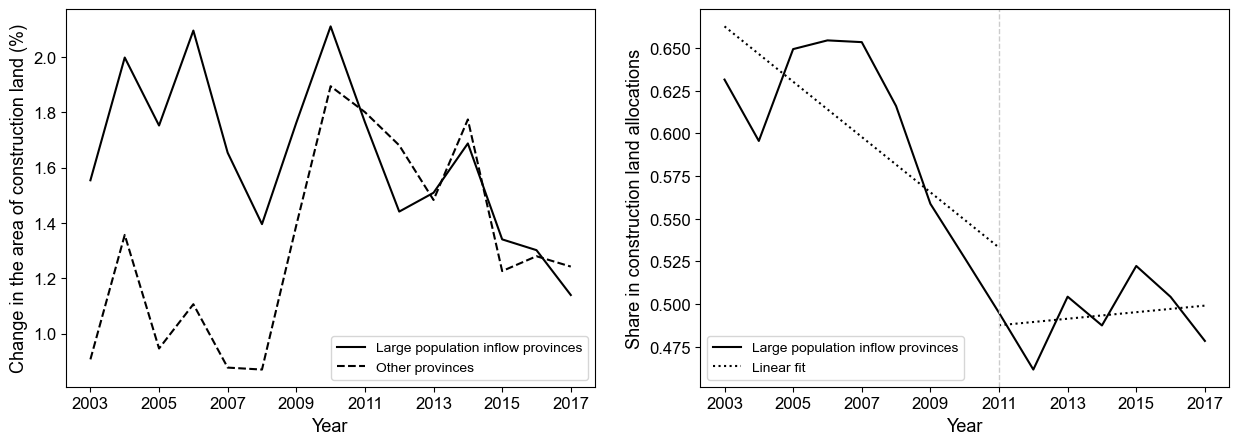

In [11]:
# land supply shares on high-inflow provinces and other provinces (Figure 3)

K0217_high = K0217[high_flow_in, :].sum(axis=0)
K0217_low = K0217[low_flow_in, :].sum(axis=0)
dK0317_high = (K0217_high[1:] / K0217_high[:-1] - 1) * 100
dK0317_low = (K0217_low[1:] / K0217_low[:-1] - 1) * 100
inout_ratio = dK0317_high / (dK0317_high + dK0317_low)
year = np.array(range(2003, 2018, 1))

fig, axes = plt.subplots(1, 2, figsize=(15,5), dpi=100)
axes[0].plot(year, dK0317_high, 'k-', label='Large population inflow provinces')
axes[0].plot(year, dK0317_low, 'k--', label='Other provinces')
axes[0].set_xlabel('Year', fontproperties=english_font, size=13)
axes[0].set_ylabel('Change in the area of construction land (%)', fontproperties=english_font, size=13)
axes[0].legend(prop=english_font)
axes[0].set_xticks(range(2003, 2018, 2))
axes[0].set_xticklabels(range(2003, 2018, 2))

axes[1].plot(year, inout_ratio, 'k-', label='Large population inflow provinces')
axes[1].set_xlabel('Year', fontproperties=english_font, size=13)
axes[1].set_ylabel('Share in construction land allocations', fontproperties=english_font, size=13)
slope1, intercept1 = np.polyfit(year[:9], inout_ratio[:9], 1)
axes[1].plot(year[:9], slope1 * year[:9] + intercept1, color='k', linestyle=':', label='Linear fit')
slope2, intercept2 = np.polyfit(year[8:], inout_ratio[8:], 1)
axes[1].plot(year[8:], slope2 * year[8:] + intercept2, color='k', linestyle=':')
axes[1].legend(prop=english_font)
axes[1].set_xticks(range(2003, 2018, 2))
axes[1].set_xticklabels(range(2003, 2018, 2))
axes[1].axvline(2011, color='0.8', ls='--', lw=1)

for tick in axes[0].get_xticklabels() + axes[0].get_yticklabels() + axes[1].get_xticklabels() + axes[1].get_yticklabels():
    tick.set_fontproperties(english_font)

axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)

plt.show()
